In [1]:
import numpy as np
import os

# Tutorial: computing load application points for CPACS

This exercise gives an overview on how to read and write CPACS data using the TiXI library and how the parametric CPACS geometry can be processed using the TiGL API and Open Cascade. The following topics are adressed:

- loading CPACS data using [**TiXI**](https://github.com/DLR-SC/tixi)
- extracting wing internal structre with [**TiGL API**](https://github.com/DLR-SC/tigl)
- geome'try operation using [**TiGL API**](https://github.com/DLR-SC/tigl) functions
- geometry operation using [**pythonOCC**](https://github.com/tpaviot/pythonocc)
- writing CPACS data using [**TiXI**](https://github.com/DLR-SC/tixi)

## 1. Load CPACS data

First we import the TiXI 3 and [open](http://tixi.sourceforge.net/Doc/group__FileHandling.html#ga748c1c28c6d9ef0c80b9633ecc379672) the file `loadCaseExample.xml`:

In [2]:
from tixi3 import tixi3wrapper

# Instantiate TiXI
tixi_h = tixi3wrapper.Tixi3()

# Open the XML file
fname = 'input.xml'
error = tixi_h.open(fname)
if not error:
    print('CPACS data set %s opended successfully.'%fname)

CPACS data set input.xml opended successfully.


Let's begin with a [schema validation](http://tixi.sourceforge.net/Doc/group__Validation.html#gacdd3338ad8d7c0a1b8bbd50ec465b93e) before we proceed:

In [3]:
xsd_file = 'cpacs_schema.xsd'
error = tixi_h.schemaValidateFromFile(xsd_file)
if not error:
    print('Hooray, the data set is valid to %s and we don\'t have to scold the input data provider :)'%xsd_file)

Hooray, the data set is valid to cpacs_schema.xsd and we don't have to scold the input data provider :)


[TiXI](https://github.com/DLR-SC/tixi) privdes an [online documentation](http://tixi.sourceforge.net/Doc/index.html) of the available C functions and a [Wiki](https://github.com/DLR-SC/tixi/wiki) with some examples and further explanations. In Python it is convenient to use the [`help()`](https://docs.python.org/3/library/functions.html#help) command to directly get an overview of the implemented functions of the wrapped API.

We will now read the required information from the CPACS data set. Since we already know that the data set is valid, we will find all information about the expected data in the [CPACS documentation](https://cpacs.de/pages/documentation.html) (he different ways to read and interpret a schema are explained in [tutorials from this workshop](https://github.com/DLR-SL/CPACS_Seminar/tree/master/HowTos)). 

The structure of the [`loadApplicationPointSets`](https://www.cpacs.de/documentation/CPACS_loadCases/html/75379068-a51b-aa5b-81fa-b0d3d4e41543.htm) can be represented as the following XSD diagram:

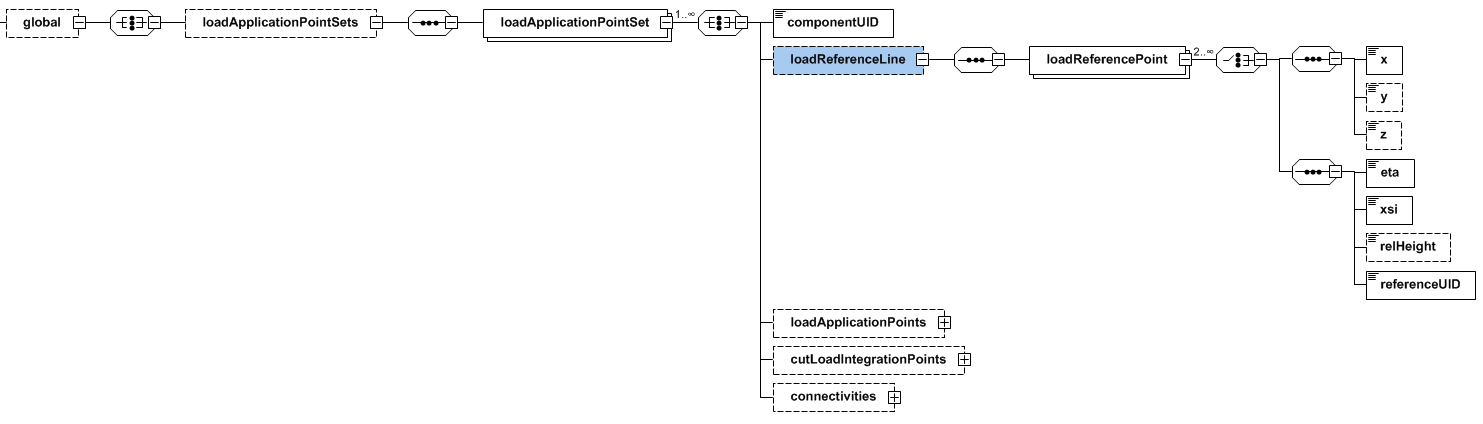

First we want to check whether the optional [`loadReferenceLine`](https://www.cpacs.de/documentation/CPACS_loadCases/html/7a985b67-4f8a-bd38-f9bf-e2e20606e591.htm) exists and import the coordinates of its nodes.

*Note: For the sake of simplicity, we make the assumptions that we expect our data in the first `loadApplicationPointSet` and that we can only process relative coordinates of the `loadReferenceLine`. Detailed error information (e.g., `else` conditions), as it should be considered in a tool implementation, is neglected as well.*

In [4]:
# Look for the first point set
xpath = '/cpacs/vehicles/aircraft/model[1]/analyses/global/loadApplicationPointSets/loadApplicationPointSet[1]'
if tixi_h.checkElement(xpath):
    
    # Extract the component uID which points to the corresponding component segment
    componentUID = tixi_h.getTextElement(xpath+'/componentUID')
    
    # Check whether a reference line is given
    xpath += '/loadReferenceLine'
    if tixi_h.checkElement(xpath):
        
        point_list = []
        # Read the point list
        for i in range(tixi_h.getNumberOfChilds(xpath)):
            
            # If <eta> is given, then relative coordinates can be expected
            point_xpath = xpath+'/loadReferencePoint[%i]'%(i+1)
            if tixi_h.checkElement(point_xpath+'/eta'):
                
                # Obligatory elements
                eta = tixi_h.getDoubleElement(point_xpath+'/eta')
                xsi = tixi_h.getDoubleElement(point_xpath+'/xsi')
                referenceUID = tixi_h.getTextElement(point_xpath+'/referenceUID')
                
                # <relHeight> is optional, so we set False to indicate that the value is not given
                if tixi_h.checkElement(point_xpath+'/relHeight'):
                    relHeight = tixi_h.getDoubleElement(point_xpath+'/relHeight')
                else:
                    relHeight = False
                point_list.append([eta,xsi,relHeight,referenceUID])


print('Reference axis points:',*point_list, sep = "\n")

Reference axis points:
[0.0, 0.3, False, 'D150_iLOADS_W1_CompSeg1']
[0.12, 0.3, 0.5, 'D150_iLOADS_W1_CompSeg1']
[1.0, 0.4, 0.5, 'D150_iLOADS_W1_CompSeg1']


We now extracted a list of points defining a reference line. In a next step we want to compute the intersection of this reference line with a the ribs to specify proper load application points for structural analysis.

## 2. Intersection of reference line with ribs

We will use the TiGL API for the basic geometry handling. The example will furthermore illustrate how to use Opencascade for individual geometry operations in case they are not implemented in TiGL.

### 2.1 Using TiGL to extract the geometry of wing, ribs and spars

Let's import `tigl3` and create an instance of TiGL3 class.

In [5]:
from tigl3 import tigl3wrapper

# Create instance of TiGL
tigl_h = tigl3wrapper.Tigl3()
tigl_h.open(tixi_h, '')

Load the configuration manager from `tigl3.configuration`:

In [6]:
import tigl3.configuration

# Load TiGL configuration manager and uID manager
mgr = tigl3.configuration.CCPACSConfigurationManager_get_instance()
aircraft_config = mgr.get_configuration(tigl_h._handle.value)
uid_mgr = aircraft_config.get_uidmanager()

Get the wing by its `uID`, the component segment by its index and retrieve the corresponding internal structure:

In [7]:
wing = uid_mgr.get_geometric_component('D150_iLOADS_W1')
component_segment = wing.get_component_segment(1)
wing_structure = component_segment.get_structure()

Now we can extract spars and ribs:

In [8]:
# List of spars
spars = []
for i in range(wing_structure.get_spar_segment_count()):
    spars.append(wing_structure.get_spar_segment(i+1))

# List of rib sets and rib faces
rib_sets = []
rib_faces = []
for i in range(wing_structure.get_ribs_definition_count()):
    print('reading rib set #%i ...'%(i+1))
    rib_set = wing_structure.get_ribs_definition(i+1)
    rib_sets.append(rib_set)
    for j in range(rib_set.get_number_of_ribs()):
        rib_faces.append(rib_set.get_rib_face(j+1))

print("\nDone with reading %i rib faces from %i rib sets!"%(len(rib_faces),i))

reading rib set #1 ...
reading rib set #2 ...
reading rib set #3 ...
reading rib set #4 ...
reading rib set #5 ...
reading rib set #6 ...
reading rib set #7 ...

Done with reading 31 rib faces from 6 rib sets!


Let's plot the result using the Open Cascade viewer. If you want to enter the event loop, i.e. using the mouse to modify the view, uncomment `start_display()`:

In [9]:
from OCC.Display.WebGl.jupyter_renderer import JupyterRenderer

In [10]:
renderer = JupyterRenderer(size=(700,700))
renderer.DisplayShape(wing.get_lower_shape(), transparency=True)
renderer.DisplayShape(wing.get_upper_shape(), transparency=True)
for spar in spars:
    renderer.DisplayShape(spar.get_spar_geometry(),shape_color="blue")
for i, rib_set in enumerate(rib_sets):
    renderer.DisplayShape(rib_set.get_ribs_geometry(),shape_color="red")
renderer.Display()

### 2.2 Converting relative component segment coordinates to absolute coordinates using the TiGL API

There is no direct TiGL method to translate the relative component segment coordinates to absolute coordinates. But we can use the TiGL API to write our own function:

In [11]:
from OCC.Core.gp import gp_Pnt

def get_abs_pnt(eta, xsi, relHeight, compUID):
    
        # Get uIDs of the corresponding wing and segment
        wing_uid, segm_uid = tigl_h.wingComponentSegmentPointGetSegmentEtaXsi(compUID,eta,xsi)[0:2]
        
        # Get the wing and segment index from its uID
        wing_index = tigl_h.wingGetIndex(wing_uid)
        segm_index = tigl_h.wingGetSegmentIndex(segm_uid)[0]
        
        if not relHeight:
            # TiGL returns absolute point coordinates on the wing chord face at eta, xsi of the segment
            pnt = tigl_h.wingGetChordPoint(wing_index,segm_index,eta,xsi)
        else:
            # Compute the unit normal vector to the chord face
            chord_normal = np.array(tigl_h.wingGetChordNormal(wing_index, segm_index, eta, xsi))
            e = chord_normal/np.linalg.norm(chord_normal)

            # Get the upper and lower intersection with the wing surface
            p_up = np.array(tigl_h.wingGetUpperPointAtDirection(wing_index, segm_index, eta, xsi, e[0], e[1], e[2])[0:3])
            p_lo = np.array(tigl_h.wingGetLowerPointAtDirection(wing_index, segm_index, eta, xsi, e[0], e[1], e[2])[0:3])

            # Translate the relHeight parameter into point coordinates
            dist = np.linalg.norm(p_up-p_lo)
            pnt = p_lo + relHeight*dist*e

        # Return the result as gp_Pnt
        return gp_Pnt(*pnt)

We call the above function for each point in our point list and write the results into a new list `abs_points`:

In [12]:
comp_uid = component_segment.get_uid()

abs_points = []
for point in point_list:
    abs_points.append(get_abs_pnt(*point))

Using the `BRepBuilderAPI_MakeEdge` class we construct edges between the nodes:

In [13]:
from OCC.Core.BRepBuilderAPI import BRepBuilderAPI_MakeEdge

edges = []
for i in range(len(abs_points)-1):
    edges.append(BRepBuilderAPI_MakeEdge(abs_points[i],abs_points[i+1]))

Let's plot the `loadReferenceLine` composed of the three point coordinates and the two edges with green color:

In [14]:
renderer = JupyterRenderer(size=(700,700))
renderer.DisplayShape(wing.get_lower_shape(), transparency=True)
renderer.DisplayShape(wing.get_upper_shape(), transparency=True)
for spar in spars:
    renderer.DisplayShape(spar.get_spar_geometry(),shape_color="blue")
for i, rib_set in enumerate(rib_sets):
    renderer.DisplayShape(rib_set.get_ribs_geometry(),shape_color="red")
for pnt in abs_points:
    renderer.DisplayShape([pnt])
for edge in edges:
    renderer.DisplayShape(edge.Edge(), edge_color="green")
renderer.Display()

### 2.3 Intersection of ribs and reference line using pythonOCC

We now have a shape for each of the ribs and the reference line. Next, we will write a routine to combine the edges to a curve and intersect this curve with the ribs. For this we will use the pythonOCC library directly. 

*Note: Threre is a [API documentation](https://cdn.rawgit.com/tpaviot/pythonocc-core/804f7f3/doc/apidoc/0.18.1/) of pythonOCC. Furthermore, it is recommended to have a look at the [Python demos](https://github.com/tpaviot/pythonocc-demos) or the [C++ documentation](https://www.opencascade.com/doc/occt-6.9.1/refman/html/index.html) from which the Python functions are derived. Again, the `help()` command is very useful to get an overview of the possible member functions of a certain class.*

The pythonOCC library usually offers several ways to get to the desired solution. In our case, we first combine the edges to a wire with [BRepBuilderAPI_MakeWire](https://cdn.rawgit.com/tpaviot/pythonocc-core/804f7f3/doc/apidoc/0.18.1/OCC.BRepBuilderAPI.html?highlight=brepbuilderapi_makewire#OCC.BRepBuilderAPI.BRepBuilderAPI_MakeWire):

In [15]:
from OCC.Core.BRepBuilderAPI import BRepBuilderAPI_MakeWire

wire_h = BRepBuilderAPI_MakeWire(edges[0].Edge(), edges[1].Edge())
wire = wire_h.Wire()

From this wire we derive the curve in form of a spline with C0 continuity using [Approx_Curve3d](https://cdn.rawgit.com/tpaviot/pythonocc-core/804f7f3/doc/apidoc/0.18.1/OCC.Approx.html?highlight=approx_curve3d#OCC.Approx.Approx_Curve3d):

In [16]:
from OCC.Core.BRepAdaptor import BRepAdaptor_CompCurve, BRepAdaptor_HCompCurve
from OCC.Core.GeomAbs import GeomAbs_C0
from OCC.Core.Approx import Approx_Curve3d

wireAdaptor = BRepAdaptor_CompCurve(wire)
curveAdaptor = BRepAdaptor_HCompCurve(wireAdaptor)
approx = Approx_Curve3d(curveAdaptor, 1e-7, GeomAbs_C0, 5, 12)
curve = approx.Curve()

In the next step we use the [`GeomAPI_IntCS`](https://cdn.rawgit.com/tpaviot/pythonocc-core/804f7f3/doc/apidoc/0.18.1/OCC.GeomAPI.html?highlight=geomapi_intcs#OCC.GeomAPI.GeomAPI_IntCS) class to intersect the curve with the rib surfaces. Therefore, the rib faces are converted to surfaces via [`BRep_Tool`](https://cdn.rawgit.com/tpaviot/pythonocc-core/804f7f3/doc/apidoc/0.18.1/OCC.BRep.html?highlight=brep_tool#OCC.BRep.BRep_Tool):

In [17]:
from OCC.Core.GeomAPI import GeomAPI_IntCS
from OCC.Core.BRep import BRep_Tool

intersector = GeomAPI_IntCS()
intersec_pnts = []
for rib_face in rib_faces:
    face = BRep_Tool.Surface(rib_face)
    intersector.Perform(curve, face)
    for i in range(intersector.NbPoints()):
        intersec_pnts.append(intersector.Point(i+1))

Let's plot the results as red points:

In [18]:
renderer = JupyterRenderer(size=(700,700))
renderer.DisplayShape(wing.get_lower_shape(), transparency=True)
renderer.DisplayShape(wing.get_upper_shape(), transparency=True)
for spar in spars:
    renderer.DisplayShape(spar.get_spar_geometry(),shape_color="blue")
for i, rib_set in enumerate(rib_sets):
    renderer.DisplayShape(rib_set.get_ribs_geometry(),shape_color="red")
for pnt in abs_points:
    renderer.DisplayShape([pnt])
for edge in edges:
    renderer.DisplayShape(edge.Edge(), edge_color="green")
for pt in intersec_pnts:
    renderer.DisplayShape([pt])
renderer.Display()

## 3. Write load application points to CPACS

We have now intersected our reference line with the internal wing structure and thus determined the load application points. Now let's write the results back to CPACS.

A look into the [online documentation](https://www.cpacs.de/documentation/CPACS_loadCases/html/378cea43-6e5e-7f71-d037-9cc342ad0a05.htm) reveals the following data structure for this:
```XML
<loadApplicationPointSet uID="wingPointSet1">
    <loadApplicationPoints>
        <pointIDs mapType="vector">1;2;...</pointIDs>
        <x mapType="vector">..;..</x>
        <y mapType="vector">..;..</y>
        <z mapType="vector">..;..</z>
    </loadApplicationPoints>
</loadApplicationPointSet>
```

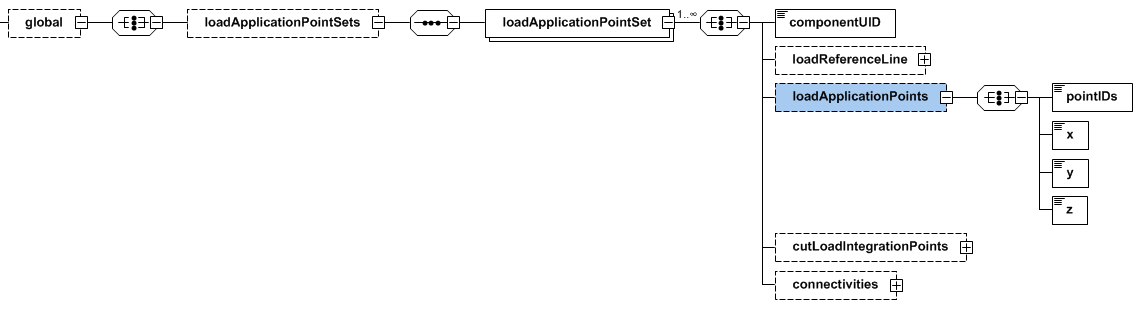

We could see from the documentation that the [coordinates](https://www.cpacs.de/documentation/CPACS_loadCases/html/8cbb5e0f-58aa-65db-8086-40d31330082d.htm) of the [load application points](https://www.cpacs.de/documentation/CPACS_loadCases/html/bf3688ab-60ba-701f-51d4-a76b2ab062ff.htm) are stored as [stringVectorBaseType](https://www.cpacs.de/documentation/CPACS_loadCases/html/32aea7db-266a-6dfa-5d16-f9b63c1e62a8.htm). Therefore we first create corresponding lists in Python:

(*Note: documentation links must be adopted to the new proposal once released*)

In [19]:
id_vec, x_vec, y_vec, z_vec = [],[],[],[]

for i, pnt in enumerate(intersec_pnts):
    id_vec.append(i+1)
    x,y,z = pnt.Coord()
    x_vec.append(x)
    y_vec.append(y)
    z_vec.append(z)

Using TiXI we [create](http://tixi.sourceforge.net/Doc/group__Elements.html#ga48de468f8e6b82bafff8465bed229068) the `loadApplicationPoints` element and [add the corresponding vectors](http://tixi.sourceforge.net/Doc/group__Elements.html#gab3d822acc72ee8e15b5c43140db1de53):

In [20]:
# Create a childe-element 'loadApplicationCoordinates'
parentPath = '/cpacs/vehicles/aircraft/model[1]/analyses/global/loadApplicationPointSets/loadApplicationPointSet[1]'
tixi_h.createElement(parentPath, 'loadApplicationPoints')

# Add coordinate vectors
parentPath += '/loadApplicationPoints'
tixi_h.addFloatVector(parentPath, 'pointIDs', id_vec, len(id_vec), '%g')
tixi_h.addFloatVector(parentPath, 'x', x_vec, len(x_vec), '%.5f')
tixi_h.addFloatVector(parentPath, 'y', y_vec, len(y_vec), '%.5f')
tixi_h.addFloatVector(parentPath, 'z', z_vec, len(z_vec), '%.5f')

Finally the results are [written](http://tixi.sourceforge.net/Doc/group__FileHandling.html#gaf1bedd335ae49ba7dc69836720b00372) to `output.xml`:

In [21]:
fname = 'output.xml'
error = tixi_h.saveDocument(fname)
if not error:
    print("Data written successfully to %s."%fname)

Data written successfully to output.xml.
